# Testing Multi-HMC Gibbs

This notebook will run through some examples using the new Multi-HMC Gibbs sampler.

First import sme packages.

In [1]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
import arviz
import corner
import matplotlib.pyplot as plt

from numpyro.infer import MCMC, NUTS, HMCGibbs
from jax import random

from MultiHMCGibbs import MultiHMCGibbs

My `custom_gibbs` file is one folder up, so add it to the python path before import (if in the same folder just keep the last line).

## 2D normal distribution

This can be sampled just fine with HMC, and has an analytic Gibbs step, so `NUTS`, `HMCGibbs`, and `MultiHMCGibbs` can all be tested head to head.

In [2]:
def model():
    x = numpyro.sample("x", dist.Normal(0.0, 2.0))
    y = numpyro.sample("y", dist.Normal(0.0, 2.0))
    numpyro.sample("obs", dist.Normal(x + y, 1.0), obs=jnp.array([1.0]))

### NUTS

In [3]:
hmc_kernel = NUTS(model)
mcmc = MCMC(
    hmc_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=4,
    chain_method='vectorized',
    progress_bar=False
)
mcmc.run(random.PRNGKey(0))

divergences per chain: [0 0 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.475,1.511,-2.448,3.186,0.02,0.014,5767.0,7022.0,1.0
y,0.416,1.505,-2.268,3.362,0.02,0.014,5884.0,7217.0,1.0


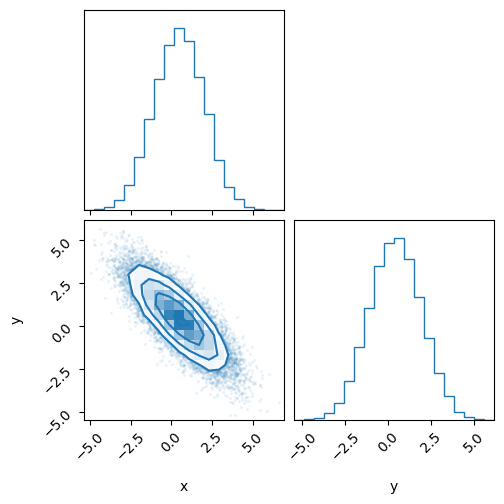

In [4]:
inf_data_hmc = arviz.from_numpyro(mcmc)
print(f'divergences per chain: {inf_data_hmc.sample_stats.diverging.values.sum(axis=1)}')
display(arviz.summary(inf_data_hmc))
fig = corner.corner(inf_data_hmc, color='C0')

## MultiHMCGibbs

To use the new `MutliHMCGibbs` you need to create a list of HMC kernels (`NUTS` in this case, each can have their own keywords such as `target_accept_prob` or `max_tree_depth`).  The other argument is a list of lists containing the **free** parameters for each of the inner kernels.

**Important**: All free parameters must be listed **exactly once** for the sampler to work.  If this is not the case a `ValueError` will be raised listing what values are either extra or missing from the list.

In [5]:
inner_kernels = [
    NUTS(model),
    NUTS(model)
]

outer_kernel = MultiHMCGibbs(
    inner_kernels,
    [['y'], ['x']]
)

mcmc_gibbs = MCMC(
    outer_kernel,
    num_warmup=1000,
    num_samples=5000,
    num_chains=4,
    chain_method='vectorized',
    progress_bar=False
)
mcmc_gibbs.run(random.PRNGKey(0))

HMC (Blue)
MultiHMCGibbs (Orange)
divergences per chain per step:
 [[0 0 0 0]
 [0 0 0 0]]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.436,1.485,-2.364,3.170,0.040,0.028,1395.0,3006.0,1.0
y,0.443,1.481,-2.270,3.275,0.041,0.029,1308.0,3488.0,1.0


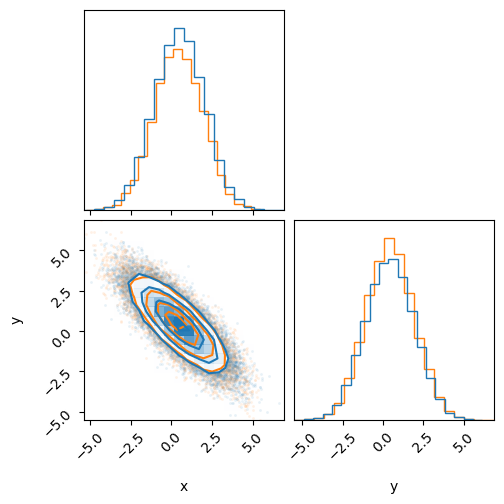

In [6]:
inf_data_gibbs = arviz.from_numpyro(mcmc_gibbs)
print('HMC (Blue)')
print('MultiHMCGibbs (Orange)')
print(f'divergences per chain per step:\n {inf_data_gibbs.sample_stats.diverging.values.sum(axis=1).T}')
display(arviz.summary(inf_data_gibbs))

fig = corner.corner(inf_data_gibbs, color='C1')
_ = corner.corner(inf_data_hmc, fig=fig, color='C0')

## HMCGibbs

This distribution has an analytic Gibbs step so it can use the built in `HMCGibbs`, let's try that and compare.  We need to use `sequential` as `vectorized` is currently broken for `HMCGibbs`.

In [7]:
def gibbs_fn(rng_key, gibbs_sites, hmc_sites):
    y = hmc_sites['y']
    new_x = dist.Normal(0.8 * (1-y), jnp.sqrt(0.8)).sample(rng_key)
    return {'x': new_x}


kernel_gibbs_fn = HMCGibbs(hmc_kernel, gibbs_fn=gibbs_fn, gibbs_sites=['x'])

mcmc_gibbs_fn = MCMC(
    kernel_gibbs_fn,
    num_warmup=1000,
    num_samples=5000,
    num_chains=4,
    chain_method='sequential',
    progress_bar=False
)

mcmc_gibbs_fn.run(random.PRNGKey(0))

HMC (Blue)
MultiHMCGibbs (Orange)
HMCGibbs (Green)


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,0.433,1.493,-2.423,3.222,0.030,0.021,2539.0,4804.0,1.0
y,0.464,1.508,-2.402,3.263,0.033,0.023,2145.0,3985.0,1.0


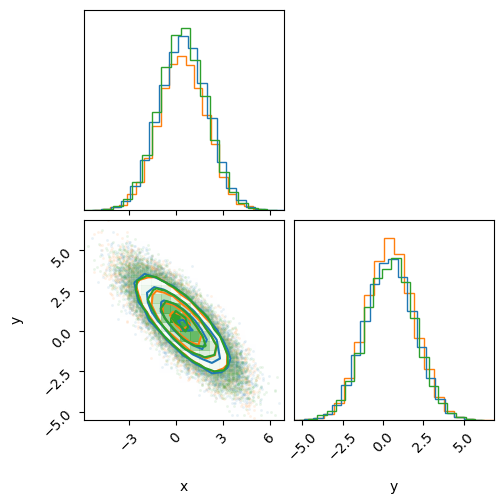

In [8]:
inf_data_gibbs_fn = arviz.from_numpyro(mcmc_gibbs_fn)
print('HMC (Blue)')
print('MultiHMCGibbs (Orange)')
print('HMCGibbs (Green)')
display(arviz.summary(inf_data_gibbs_fn))

fig = corner.corner(inf_data_gibbs, color='C1')
_ = corner.corner(inf_data_hmc, fig=fig, color='C0')
_ = corner.corner(inf_data_gibbs_fn, fig=fig, color='C2')

In all three cases we got the same results!

## Neal's Funnel

Now lets take a distribution where a Gibbs step is needed to get a decent result.

In [9]:
def model(dim=10):
    y = numpyro.sample("y", dist.Normal(0, 3))
    numpyro.sample("x", dist.Normal(jnp.zeros(dim - 1), jnp.exp(y / 2)))

In [10]:
def run_inference(kernel, chain_method, rng_key):
    mcmc = MCMC(
        kernel,
        num_warmup=8000,
        num_samples=5000,
        num_chains=4,
        chain_method=chain_method,
        progress_bar=False
    )
    mcmc.run(rng_key)
    return mcmc

## NUTS

We will use a large `target_accept_prob` to get rid of most divergent samples and use a large number of warmup and samples to get the `r_hat`s down.

In [11]:
funnel_mcmc_hmc = run_inference(NUTS(model, target_accept_prob=0.995), 'vectorized', random.PRNGKey(0))
inf_funnle_hmc = arviz.from_numpyro(funnel_mcmc_hmc)
print(f'divergences per chain: {inf_funnle_hmc.sample_stats.diverging.values.sum(axis=1)}')
display(arviz.summary(inf_funnle_hmc))

divergences per chain: [0 1 0 0]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],0.023,7.549,-9.132,8.779,0.070,0.123,21744.0,1244.0,1.02
x[1],-0.000,6.463,-7.872,8.200,0.059,0.122,19342.0,1341.0,1.01
x[2],-0.026,7.829,-7.953,8.299,0.069,0.133,21151.0,1302.0,1.01
x[3],-0.022,8.001,-8.716,8.269,0.078,0.141,21511.0,1321.0,1.01
x[4],-0.035,7.819,-8.130,7.957,0.100,0.123,13318.0,1341.0,1.01
x[5],0.042,7.795,-8.942,8.457,0.089,0.134,16590.0,1326.0,1.01
x[6],0.004,7.751,-8.649,8.611,0.090,0.105,18612.0,1286.0,1.02
x[7],0.056,7.642,-9.249,8.517,0.070,0.122,19219.0,1304.0,1.01
x[8],0.124,7.171,-8.696,8.252,0.072,0.101,22774.0,1350.0,1.01
y,0.144,2.851,-4.930,5.524,0.240,0.170,133.0,99.0,1.02


In [12]:
x_marginal_true = jnp.linspace(-10, 10, 1000)
y_marginal_true = jnp.exp(dist.Normal(0, 3).log_prob(x_marginal_true))

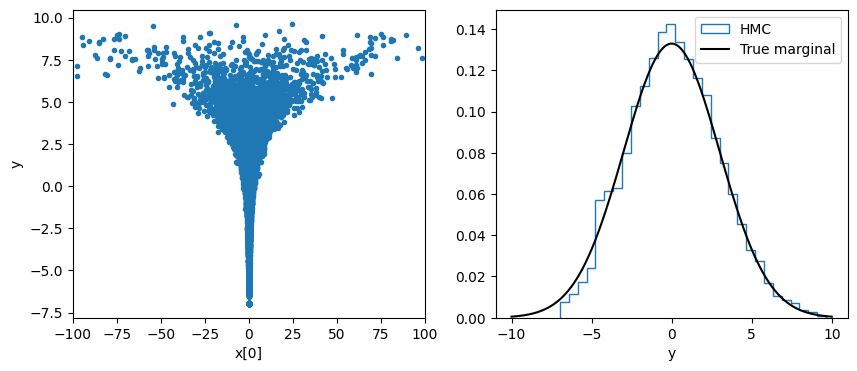

In [13]:
x_model_hmc = inf_funnle_hmc.posterior.x[..., 0].data.flatten()
y_model_hmc = inf_funnle_hmc.posterior.y.data.flatten()

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(x_model_hmc, y_model_hmc, '.')
plt.xlabel('x[0]')
plt.ylabel('y')
plt.xlim(-100, 100)
plt.subplot(122)
plt.hist(y_model_hmc, bins=30, histtype='step', density=True, label='HMC')
plt.plot(x_marginal_true, y_marginal_true, color='k', label='True marginal')
plt.xlabel('y')
plt.legend();

We can see that `NUTS` is struggling with this model.  We can see that the `y` marginal is still missing a bit of negative values at the bottom of the funnel.

## MultiHMCGibbs

For the `MultiHMCGibbs` sampler we will only put a large `target_accept_prob` on the `x` values (as these are the difficult ones to draw), but keep the default value for the `y` values.  To keep it on the same footing as the previous run we will use the same number of warm up and sample draws.

In [14]:
funnel_mcmc_gibbs = run_inference(
    MultiHMCGibbs(
        [NUTS(model, target_accept_prob=0.995), NUTS(model, target_accept_prob=0.8)],
        [['x'], ['y']]
    ),
    'vectorized',
    random.PRNGKey(0)
)
inf_funnle_gibbs = arviz.from_numpyro(funnel_mcmc_gibbs)
print(f'divergences per chain per step:\n {inf_funnle_gibbs.sample_stats.diverging.values.sum(axis=1).T}')
display(arviz.summary(inf_funnle_gibbs))

divergences per chain per step:
 [[0 1 8 3]
 [0 0 0 0]]


/Users/coleman/anaconda3/envs/lensing/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],-0.155,6.789,-8.912,9.231,0.170,0.237,9769.0,646.0,1.01
x[1],-0.468,9.696,-9.710,9.083,0.462,0.353,5775.0,559.0,1.01
x[2],0.470,6.962,-9.728,9.047,0.185,0.211,6786.0,502.0,1.01
x[3],-0.073,6.513,-9.195,9.341,0.120,0.192,10569.0,620.0,1.01
x[4],0.157,7.899,-8.994,9.742,0.186,0.239,7744.0,587.0,1.01
x[5],0.256,7.162,-10.120,8.879,0.179,0.208,8676.0,495.0,1.01
x[6],0.355,8.593,-8.220,9.936,0.378,0.316,5336.0,480.0,1.01
x[7],0.123,7.682,-9.990,8.397,0.283,0.291,6507.0,550.0,1.01
x[8],-0.095,6.695,-8.956,10.158,0.167,0.209,7437.0,598.0,1.01
y,0.065,3.084,-5.616,5.847,0.283,0.201,119.0,275.0,1.02


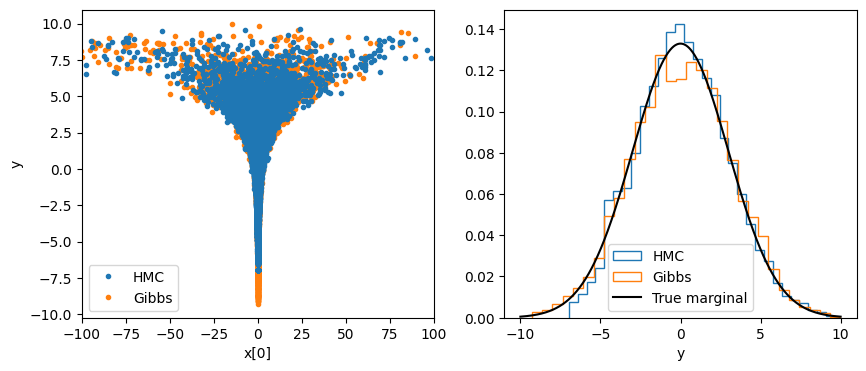

In [15]:
x_model_gibbs = inf_funnle_gibbs.posterior.x[..., 0].data.flatten()
y_model_gibbs = inf_funnle_gibbs.posterior.y.data.flatten()

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(x_model_hmc, y_model_hmc, '.', label='HMC', zorder=2)
plt.plot(x_model_gibbs, y_model_gibbs, '.', label='Gibbs', zorder=1)
plt.xlabel('x[0]')
plt.ylabel('y')
plt.legend()
plt.xlim(-100, 100)
plt.subplot(122)
plt.hist(y_model_hmc, bins=30, histtype='step', label='HMC', density=True)
plt.hist(y_model_gibbs, bins=30, histtype='step', label='Gibbs', density=True)
plt.plot(x_marginal_true, y_marginal_true, color='k', label='True marginal')
plt.xlabel('y')
plt.legend();

We can see that with the same set up `MultiHMCGibbs` was able to reach deeper into the funnel and pull out the negative `y` values missed by `NUTS`.

## Other notes

- You can use as many `inner_kernels` as you want
- The order the kernels are stepped in is set by the order of the parameter list (in the example above `x` septs first, followed by `y`)
- The order matters!  Typically you want to step the parameters closest to the likelihood first and the hyper-parameters second.  But for some models this might not be so clear, so some experimentation could be needed.